In [131]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self, latent_size, multiplier=4, img_size=64):
        super(AE, self).__init__()
        out_channels = 1
        self.fm = img_size // 16
        self.mp = multiplier
        self.encoder = nn.Sequential(
            nn.Conv2d(1, int(16 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(16 * multiplier)),
            nn.ReLU(True),
            nn.Conv2d(int(16 * multiplier),
                      int(32 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(32 * multiplier)),
            nn.ReLU(True),
            nn.Conv2d(int(32 * multiplier),
                      int(64 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(64 * multiplier)),
            nn.ReLU(True),
            nn.Conv2d(int(64 * multiplier),
                      int(64 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(64 * multiplier)),
            nn.ReLU(True),
        )
        self.linear_enc = nn.Sequential(
            nn.Linear(int(64 * multiplier) * self.fm*self.fm, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Linear(2048, latent_size),
        )
        

        self.linear_dec = nn.Sequential(
            nn.Linear(latent_size, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Linear(2048, int(64 * multiplier) * self.fm*self.fm),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(int(64*multiplier), int(64 *
                                                       multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(64*multiplier)),
            nn.ReLU(True),
            nn.ConvTranspose2d(int(64*multiplier), int(32 *
                                                       multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(32*multiplier)),
            nn.ReLU(True),
            nn.ConvTranspose2d(int(32*multiplier), int(16 *
                                                       multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(16*multiplier)),
            nn.ReLU(True),
            nn.ConvTranspose2d(int(16*multiplier),
                               out_channels, 4, 2, 1, bias=False),
        )

    def forward(self, x):
        lat_rep = self.feature(x)
        out = self.decode(lat_rep)
        return out

    def feature(self, x):
        lat_rep = self.encoder(x)
        lat_rep = lat_rep.view(lat_rep.size(0), -1)
        lat_rep = self.linear_enc(lat_rep)
        return lat_rep

    def decode(self, x):
        out = self.linear_dec(x)
        out = out.view(out.size(0), int(64 * self.mp), self.fm, self.fm)
        out = self.decoder(out)
        return out


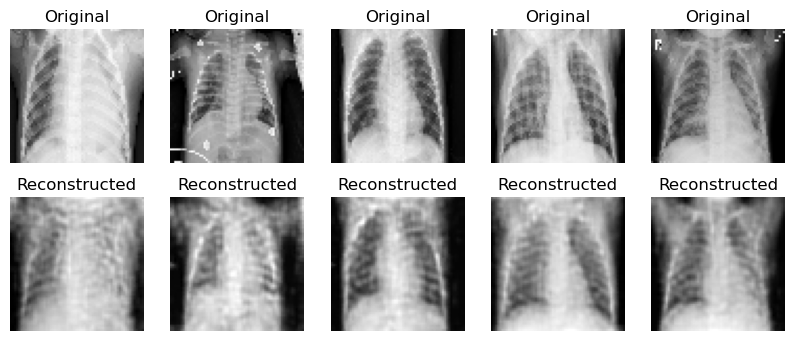

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [139]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn.metrics import accuracy_score

BATCH_SIZE = 64
IMG_SIZE = 64

# Load preprocessed data
X_train = np.load('X_train_gray_noraml.npy')
y_train = np.load('y_train_gray_normal.npy')

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Define dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


# Load preprocessed data
X_test = np.load('X_test_gray.npy')
y_test = np.load('y_test_gray.npy')

# Convert data to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


# Define dataset and dataloader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


def train_loop(model, loader, test_loader):
    optim = torch.optim.Adam(model.parameters(), 5e-4, betas=(0.5, 0.999))
    EPOCHS = 250
    for e in tqdm(range(EPOCHS)):
        model.train()
        for (x, _) in loader:
            x.requires_grad = False
            x.permute(0, 3, 1, 2)
            out = model(x)
            rec_err = (out - x) ** 2
            loss = rec_err.mean()
            optim.zero_grad()
            loss.backward()
            optim.step()
    torch.save(model.state_dict(), './models/AE_gray.pth')
    test_for_xray( model, test_loader)

def plotImages(out, x):
    out_np = out.detach().numpy()
    x_np = x.detach().numpy()

    # Plot original images
    plt.figure(figsize=(10, 4))
    for i in range(5):  # Plotting first 5 images as an example
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_np[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

    # Plot reconstructed images
    for i in range(5):  # Plotting first 5 images as an example
        plt.subplot(2, 5, i + 6)
        plt.imshow(out_np[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

def test_for_xray(model=None, loader=None, vae=False):
    model.eval()
    flag = True
    with torch.no_grad():
        y_score, y_true = [], []
        for (x, label) in loader:
            x.permute(0, 3, 1, 2)
            out = model(x)
            if flag:
                flag = False
                plotImages(out, x)
            rec_err = (out - x) ** 2
            res = rec_err
            res = res.mean(dim=(1,2,3))
            y_true.append(label)
            y_score.append(res.view(-1))

        y_true = np.concatenate(y_true)
        y_score = np.concatenate(y_score)
        auc = metrics.roc_auc_score(y_true, y_score)
        print('AUC', auc)
        plt.figure()
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        return auc

if __name__ == '__main__':
    model = AE( latent_size=IMG_SIZE)
    # train_loop(model, train_loader, test_loader)
    model_path = "./models/AE_gray.pth"
    model.load_state_dict(torch.load(model_path))
    test_for_xray(model, test_loader)